# FASHION-MNIST dataset  -- Classification using neural network with fully connected layers

In [ ]:
!pip install sh

In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchsummary
import torchvision
import matplotlib.pyplot as plt

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Loading, Preprocessing and Exploration

### Dataset Loading and Splitting

In [3]:
import os
import urllib.request
from sh import gunzip
import numpy as np
from sklearn.model_selection import train_test_split
from mlxtend.data import loadlocal_mnist

class FashionMnistLoader:
    
    dir_name = "data/fashion"
    url_train_imgs = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz"
    url_train_labels = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz"
    url_test_imgs = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz"
    url_test_labels = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz"
    
    def __init__(self):
        self.train_imgs_fn = None
        self.train_labels_fn = None
        self.test_imgs_fn = None
        self.test_labels_fn = None
        
    def get_data(self, url):
        gz_file_name = url.split("/")[-1]
        gz_file_path = os.path.join(self.dir_name, gz_file_name)  
        file_name = gz_file_name.split(".")[0]
        file_path = os.path.join(self.dir_name, file_name)
        os.makedirs(self.dir_name, exist_ok=True)
        if not os.path.exists(file_path):
            urllib.request.urlretrieve(url, gz_file_path) 
            gunzip(gz_file_path)  
        return file_path
        
    def get_all_data(self):
        self.train_imgs_fn = self.get_data(self.url_train_imgs)
        self.train_labels_fn = self.get_data(self.url_train_labels)
        self.test_imgs_fn = self.get_data(self.url_test_imgs)
        self.test_labels_fn = self.get_data(self.url_test_labels)
        return self
    
    def load_train(self):
        X, y = loadlocal_mnist(
            images_path=self.train_imgs_fn, 
            labels_path=self.train_labels_fn)
        return X, y
    
    def load_test(self):
        X, y = loadlocal_mnist(
            images_path=self.test_imgs_fn, 
            labels_path=self.test_labels_fn)
        return X, y
    
    def _split(self, X, y, test_size):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=666)
        return X_train, X_test, y_train, y_test
            
    def train_split(self, test_size):
        X, y = self.load_train()
        X_train, X_test, y_train, y_test = self._split(X, y, test_size)
        return X_train, X_test, y_train, y_test

    def standard_split(self):
        X_train, y_train = self.load_train()
        X_test, y_test = self.load_test()
        return X_train, X_test, y_train, y_test

    

In [4]:
data_loader = FashionMnistLoader().get_all_data()

X_train_dev, X_test, y_train_dev, y_test = data_loader.standard_split()
X_train_dev.shape, X_test.shape, len(y_train_dev), len(y_test)

((60000, 784), (10000, 784), 60000, 10000)

In [5]:
X_train, X_dev, y_train, y_dev = data_loader.train_split(1/6)
X_train.shape, X_dev.shape, len(y_train), len(y_dev)

((50000, 784), (10000, 784), 50000, 10000)

``` torch.utils.data.Dataset``` is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

- ```__len__``` so that ```len(dataset)``` returns the size of the dataset.
- ```__getitem__``` to support the indexing such that ```dataset[i]``` can be used to get ith sample

Our dataset will as well apply a processing to each sample whenever we get an item by id, this is done by applying a ```transforms```. 

Let’s say we want to normalize the values of each sample and pass it to tensors. ```torchvision.transforms.Compose``` is a simple callable class which allows us to concatenate more than one transform. 

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

transform = transforms.Compose(
    [transforms.ToPILImage(), transforms.ToTensor(), transforms.Normalize([0], [1])])

class FashionMnist(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.data = (torch.from_numpy(X).float()/255).reshape(-1, 1, 28, 28).squeeze()
        self.target = torch.from_numpy(y).long()
        self.transform = transform
        
    def __len__(self):
        return len(self.target)
        
    def __getitem__(self, index):
        img, tar = self.data[index], self.target[index]
        if self.transform:
            img = self.transform(img)
        return img, tar
    
train_dataset = FashionMnist(X_train, y_train, transform=transform)
dev_dataset = FashionMnist(X_dev, y_dev, transform=transform)

In [7]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(classes)

```torch.utils.data.DataLoader``` is an iterator which provides all these features:
- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.

Parameters used below should be clear. One parameter of interest is ```collate_fn```. You can specify how exactly the samples need to be batched using collate_fn. However, default collate should work fine for most use cases.

In [8]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True)

In [9]:
dataiter = iter(train_loader)
images_pt, labels = dataiter.next()

### Let's look a bit at data

In [10]:
images = images_pt.numpy()

In [11]:
images[0].max()

1.0

In [12]:
images[0].min()

0.0

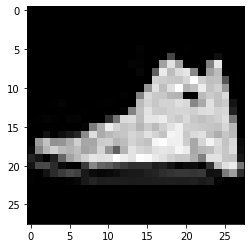

In [13]:
plt.imshow(np.squeeze(images[0]), cmap='gray')

In [14]:
classes[labels[0]]

'Sneaker'

In [15]:
images.shape

(16, 1, 28, 28)

#### What is that

(`batch size`, `number of channels`, `y`, `x`)

So we will have to __flatten__ it!!!

In [16]:
images_pt.reshape(images_pt.size(0), -1).shape

torch.Size([16, 784])

Let's look a bit more on images.

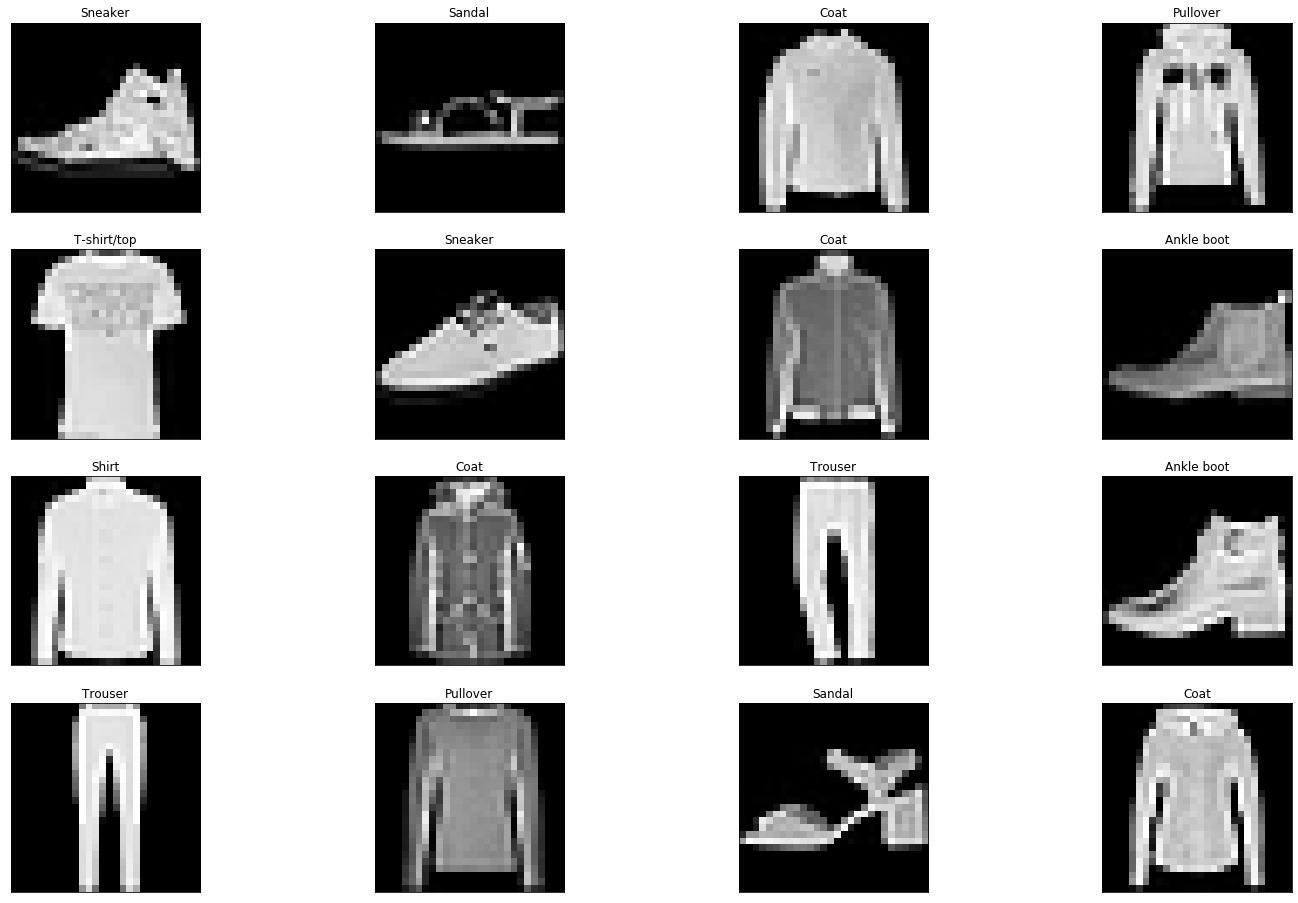

In [17]:
fig = plt.figure(figsize=(25, 16))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

In [18]:
idx = np.random.choice(batch_size)
img = np.squeeze(images[idx])

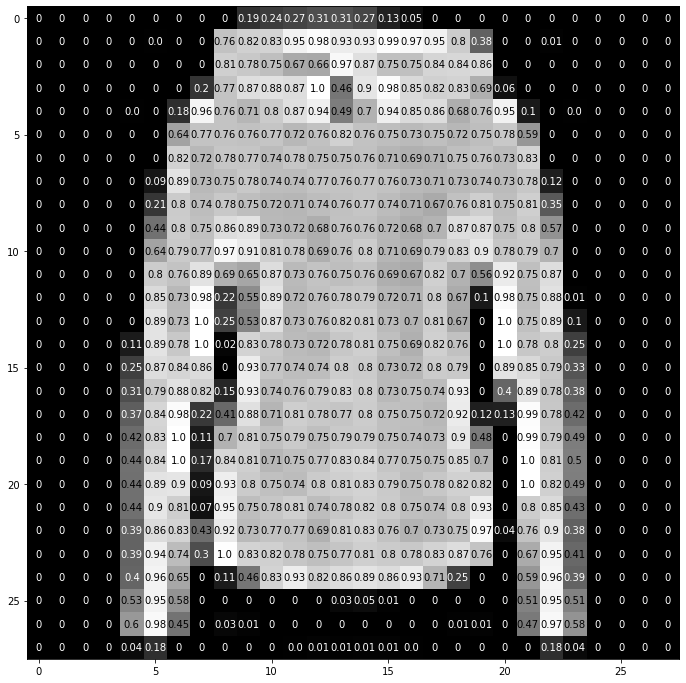

In [19]:
# display the pixel values in that image
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y], 2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [20]:
### Exercise
# Try try different parameters for the normalization in the transform


## Let's define Neural Network with pytorch

In [21]:
from torch import nn
from torch import optim
import torch.nn.functional as F

### Reminder of Logistic Regression
Let's remember Logistic Regression. Recall that output is a probablity and can be written as. 

$$y = f(w_1 x_1 + w_2 x_2 + w_3 x_3 + b)$$

where $f$ here is the sigmoid function given by formula:

$$f(x) = \frac{1}{1 + \exp(-x)}.$$

Then we can represent it as

![Simple Neuron 1](docs/pngs/logreg1.png)

We call $f$ by __activation function__ since it relates to __perceptron__, a mathematical model of a neuron. We can think about inputs as signals that a perceptron receives. Then preceptron pust them all together and $f$ activates that is take a decision if the sample belongs to the traget class or not. 

Often we simplify this picture by ploting is as

![Simple Neuron 2](docs/pngs/logreg2.png)

### Some activations

#### Sigmoid

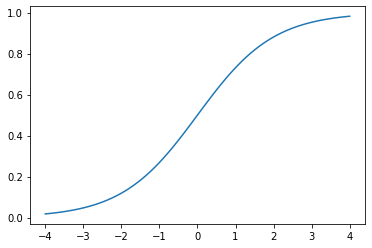

In [22]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))


x = np.linspace(-4, 4, 100)
plt.plot(x, sigmoid(x))
plt.show()

#### Identity

We can see Linear Regression as perceptron with identity activation. That is

$$f(x) = x.$$

#### Hyperbolic tangent

This one is very popular when we need an oputput that is a number between $(-1, 1)$.

$$f(x) = \frac{2}{1 + \exp(-2x)} - 1$$

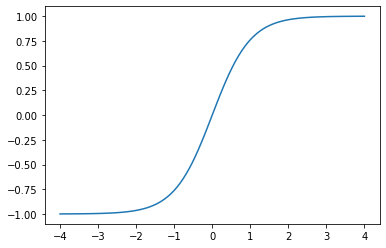

In [23]:
def tanh(x):
    return 2/(1 + np.exp(-2* x)) - 1

plt.plot(x, tanh(x))
plt.show()

#### ReLU

$$f(x) = \left\{ \begin{array}{lll} 0 & \textrm{for} & x < 0\\ x & \textrm{for} & x \geq 0 \end{array}\right.$$

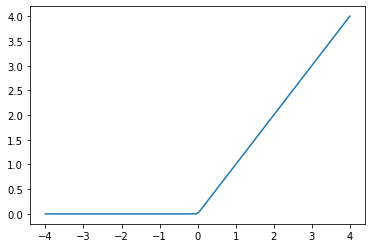

In [24]:
def relu(x):
    return (x >= 0) * x

plt.plot(x, relu(x))
plt.show()

### Neural Network

The neural network is a structure that joins together perceptrons. Here we can see an example of it.

![Simple Neuron 2](docs/pngs/nn.png)


### Defining a Neural Network
Sometimes you will want to specify models that are more complex than a sequence of existing Modules; for these cases you can define your own Modules by subclassing ```nn.Module``` and defining a ```forward``` which receives input Tensors and produces output Tensors using other modules or other autograd operations on Tensors.

In this example we implement our two-layer network as a custom Module subclass:

In [25]:
input_dim = 28 * 28

class LinearNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
model = LinearNN()


The learnable parameters of a model are returned by ```model.parameters()``` and ```model.named_parameters()```

In [26]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0105,  0.0173, -0.0304,  ...,  0.0084,  0.0076, -0.0137],
         [-0.0158, -0.0013, -0.0243,  ...,  0.0026,  0.0108, -0.0102],
         [ 0.0059, -0.0268,  0.0284,  ...,  0.0217, -0.0326,  0.0187],
         ...,
         [-0.0034,  0.0010, -0.0088,  ..., -0.0185,  0.0208,  0.0226],
         [ 0.0018, -0.0346, -0.0255,  ..., -0.0099,  0.0132,  0.0297],
         [-0.0230,  0.0302, -0.0025,  ..., -0.0004,  0.0199, -0.0251]],
        requires_grad=True), Parameter containing:
 tensor([-0.0190,  0.0050,  0.0096, -0.0289, -0.0059, -0.0052,  0.0016,  0.0290,
          0.0271, -0.0177, -0.0204,  0.0038,  0.0108, -0.0238, -0.0180, -0.0163,
         -0.0271,  0.0125, -0.0081,  0.0260,  0.0147,  0.0265,  0.0280, -0.0038,
         -0.0070,  0.0259, -0.0320,  0.0077, -0.0011, -0.0003,  0.0030, -0.0284,
         -0.0288, -0.0095, -0.0124,  0.0077,  0.0151, -0.0108, -0.0125,  0.0032,
         -0.0138, -0.0192,  0.0070,  0.0148,  0.0345, -0.0004,  0.0208,  0.0242,

In [27]:
print({name: (val.shape,val.numel()) for name, val in model.named_parameters()})

{'fc1.weight': (torch.Size([64, 784]), 50176), 'fc1.bias': (torch.Size([64]), 64), 'fc2.weight': (torch.Size([10, 64]), 640), 'fc2.bias': (torch.Size([10]), 10)}


In [28]:
# Compute the number of parameters of the model and implement a method to compute it.
def compute_parameter_number(model):
    ### your code goes here
    num_param = sum([val.numel() for _, val in model.named_parameters()])
    return num_param

compute_parameter_number(model)

50890

### Defining the loss criteria and the optimizer

Let us list the most important loss criteria functions.

#### MSE

This is the one you vary likely to know. If $y_i$ are the real values and $\hat{y}_i$ are predicted, then

$$MSE(y, \hat{y}) = \frac{1}{N}\sum_i^N (y_i - \hat{y}_i)^2.$$

#### Binary cross entropy

This one is used whan we have binary classification problem. Here $y_i \in \{0, 1\}$ and $\hat{y}_i$ is predicted probablity that the output belongs to target class. Then __binary cross entropy__ is definied by:

$$bce(y, \hat{y}) = -\sum_{i} \big(y_i \log(\hat{y}_i) + (1- y_i) \log(1-\hat{y}_i)\big).$$

#### Cross entropy

This is used when we have more than one class. Let assume that we have $j=1,\ldots, K$ classes and $y_{i,j}$ is one-hot-encodig of the outcome. That is $y_{i,j}$ is one if outcome is class $j$ and 0 otherwise. And let 
$\hat{y}_{i, j}$ be the predicted probablity that the sample $i$ belongs to class $j$. Then

$$bce(y, \hat{y}) = -\sum_{i} \sum_j y_{i, j} \log(\hat{y}_{i, j}).$$

In [29]:
criterion = nn.CrossEntropyLoss()

Define the optimizer. We will come back to it later.

In [30]:
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Let's see how it performs before training
After we have created neural network its weights are initialized randomly.

In [31]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)

In [32]:
correct = 0
total = 0

for images, labels in test_loader:

    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum()

accuracy = 100.0 * correct.item() / total

print(accuracy,"%")

12.15 %


## Let's train it

After we have created neural network its weights are initialized randomly. Then we need to train the network. We do this by repeating the following steps.

1. Forward pass
2. Calculate loss
3. Backpropagate erros: calculate gradients
4. Update weights

Let us expalain them now. 

### 1. Forward pass

Here we calculate the outcome of the network. That is, using the inputs values we calculate our predictions.

### 2. Calculate loss

Having real and predicted values we calculate loss. What is loss. It is similar to the measure of the errors. However, due to the way we update our weights (see below) this function has to be differentable or differentiable in all points except as little points as possible. 

### 3. Backpropagate erros

Next we calculate partial derivatives of the loss function with respect to weithgs. The vector of these derivaties is called __gradient__. We do not enter into details with it. It is enought to know that the vector oposite to the gradient point into direction in which we have to correct the weights in order to improve the performance of our neural network.

### 4. Update weights using optimizer

Here we are describe how __gradient descent__ optimizer works. It works by updating weights by substructing a fraction of the derivate from it. How much of it? It is another parameter called __learning rate__. So if the weight was $w_i$ and the partial derivative of the loss function $L$ with respect to $w_i$ is 

$$\frac{\partial L}{\partial w_i}$$

and the learing rate is $r$ then new weight is

$$w_i - r \frac{\partial L}{\partial w_i}.$$

In practice we use a modification of this method that is called __Adam__.

In [33]:
def train(n_epochs):
    
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = model(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time


In [34]:
n_epochs = 2 # start small to see if your model works, initially
model.train() # put model in train mode (important with, for example, dropouts, batch normalizations...)

training_loss = train(n_epochs) # call train and record the loss over time

Epoch: 1, Batch: 1000, Avg. Loss: 0.6455388148501515
Epoch: 1, Batch: 2000, Avg. Loss: 0.5534525103121996
Epoch: 1, Batch: 3000, Avg. Loss: 0.5047064200267196
Epoch: 2, Batch: 1000, Avg. Loss: 0.47796758368611336
Epoch: 2, Batch: 2000, Avg. Loss: 0.48901742324978115
Epoch: 2, Batch: 3000, Avg. Loss: 0.46973387511819603
Finished Training


In [35]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
model.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    # forward pass to get outputs
    outputs = model(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

Test Loss: 0.508288



In [36]:
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Accuracy of T-shirt/top: 88% (915/1034)
Test Accuracy of Trouser: 94% (947/1005)
Test Accuracy of Pullover: 81% (820/1001)
Test Accuracy of Dress: 81% (794/979)
Test Accuracy of  Coat: 78% (753/959)
Test Accuracy of Sandal: 98% (986/1004)
Test Accuracy of Shirt: 42% (424/1007)
Test Accuracy of Sneaker: 83% (842/1009)
Test Accuracy of   Bag: 96% (986/1027)
Test Accuracy of Ankle boot: 88% (863/975)

Test Accuracy (Overall): 83% (8330/10000)


## Some more insights

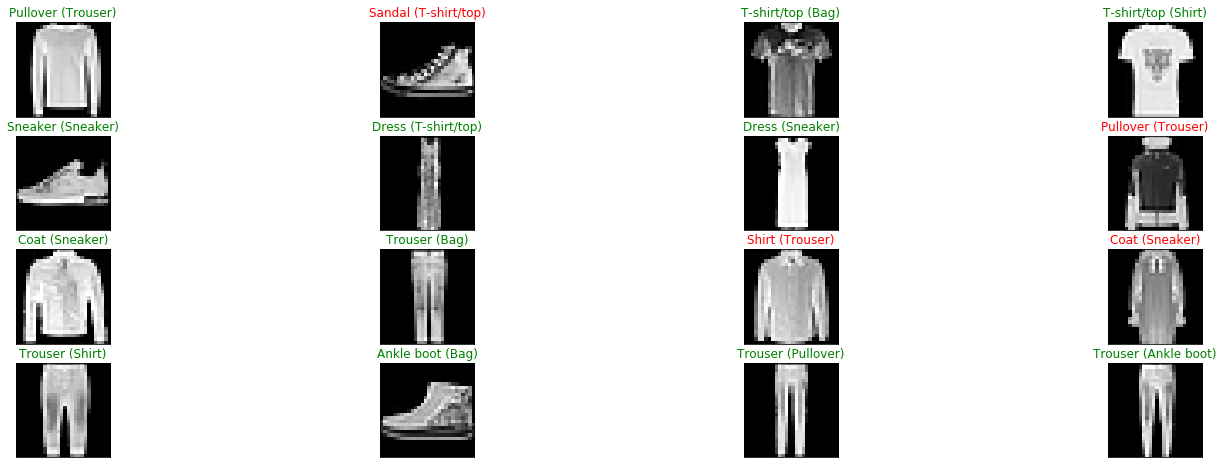

In [37]:
batch_size=16
test_loader2 = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)

# obtain one batch of test images
dataiter2 = iter(test_loader2)
images2, labels2 = dataiter2.next()
# get predictions
outputs = model(images2)
preds = np.squeeze(outputs.data.max(1, keepdim=True)[1].numpy())
images2 = images2.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 8))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images2[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels2[idx] else "red"))

In [38]:
from sklearn.metrics import confusion_matrix

batch_size=10000
test_loader3 = torch.utils.data.DataLoader(dev_dataset, batch_size=10000, shuffle=True)
dataiter3 = iter(test_loader3)
images3, labels3 = dataiter3.next()
outputs = model(images3)
array  = confusion_matrix(labels3, np.squeeze(outputs.data.max(1, keepdim=True)[1].numpy()))

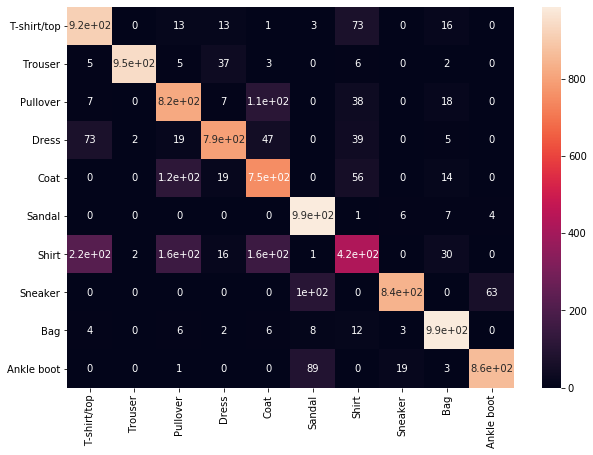

In [39]:
import pandas as pd
import seaborn as sn

df_cm = pd.DataFrame(array, index = [i for i in classes],
                  columns = [i for i in classes ])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# Explore different architectures and configurations

In [40]:
# Create nn.Module with different number of layers and sizes and 
# let's see who gets higher accuracy :)

## your code goes here

# Optimizers, Gradients and BackPropagation

When a neural network is trained, we need to compute gradients of the loss function, with respect to every weight and bias, and then update these weights using gradient descent.

With neural networks hitting billions of weights, doing the above step efficiently can make or break the feasibility of training.

## Drivatives: How autograd works

$$x_1 = \left[\begin{array}{l}
x_1^1\\
x_1^2
\end{array}\right]=
\left[\begin{array}{l}
0.1\\
0.2 
\end{array}\right]
$$

$$ x_2 = \left[\begin{array}{l}
x_2^1\\
x_2^2
\end{array}\right]=
\left[\begin{array}{l}
0.1\\
0.1 
\end{array}\right]
$$

$$y = 3\cdot x_1 + x_2 +  
\left[\begin{array}{l}
    1\\
    1
\end{array}\right] = 
\left[\begin{array}{l}
    3x_1^1 + x_1^1 + 1\\
    3x_1^2 + x_2^2 + 1
\end{array}\right]$$

$$f(x_1, x_2) = \textrm{mean}(y) = \frac{1}{2}(3x_1^1 + x_1^1 + 1 + 3x_1^2 + x_2^2 + 1)$$

$$(\nabla f)_{x_1} = \left[\begin{array}{l}
    \frac{\partial f}{\partial x_1^1}\\
    \frac{\partial f}{\partial x_1^2}
\end{array}\right] = 
\left[\begin{array}{l}
    1.5\\
    1.5
\end{array}\right] 
$$

### Now in pytorch


In [ ]:
x1 = torch.tensor([0.1, 0.2], requires_grad=True)
x2 = torch.tensor([0.1, 0.1], requires_grad=True)
y = 3 * x1 + x2 + 1
y

In [ ]:
output = y.mean()

output.backward()
print(x1.grad, x2.grad)

The method `backward` calculates gradients. __It does not put them to zero!__ But there is a convinient method for that.

In [ ]:
y = 3 * x1 + x2 + 1
output = y.mean()
output.backward()
print(x1.grad, x2.grad)

## Let's check if more complicated derivatives are calculated correctly

We start with $x = 2$.

$y = f(x) = x^2 - 3$, $f(2) = 2^2 - 3 = 1$.

$z = g(y) = y^3 - 2y$, $g(f(2)) = g(1) = 1^3 - 2\cdot 1 = -1$

In [ ]:
x = torch.tensor([2.0], requires_grad=True)
print("x = ", x)
y = x**2 - 3
print("y = ", y)
z = y**3 - 2*y
print("z = ", z)

__Tensors:__ In simple words, its just an n-dimensional array in PyTorch.  They hold
- ```.data```: Value
- ```.grad```: This is basically the gradient computed up to this particular node, and the gradient of the every subsequent node, can be computed by multiplying the edge weight with the gradient computed at the node just before it.
- ```.grad_fn```: Stores the function ```Function``` to compute the gradient to be propagated.


On setting ```.requires_grad = True``` they start forming a backward graph that tracks every operation applied on them to calculate the gradients using something called a __dynamic computation graph (DCG)__. When you finish your computation you can call ```.backward()``` and have all the gradients computed automatically. The gradient for this tensor will be accumulated into ```.grad``` attribute.



Full description of how automatic differentiation works can be found here:
https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec10.pdf

#### Chain rule
$(g(f(x))' = g'(f(x))\cdot f'(x)$

#### Derivaties
$f'(x) = 2x$, $f'(2) = 2\cdot 2 = 4$

$g'(y) = 3y^2 - 2$, $g'(f(2)) = g'(1) = 3 - 2 = 1$

$(g(f(2))'=g'(f(2))\cdot f(2) = 4 \cdot 1 = 4$

In [ ]:
z.backward()
x.grad


```Tensor``` and ```Function``` are interconnected and build up an acyclic graph, that encodes a complete history of computation. Each tensor has a ```.grad_fn``` attribute that references a ```Function``` that has created the Tensor (except for Tensors created by the user - their ```grad_fn``` is None).

In [ ]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

In [ ]:
y = x + 2
print(y)

In [ ]:
z = y * y * 3
out = z.mean()

print(z, out)

You can also stop autograd from tracking history on Tensors with ```.requires_grad=True``` by wrapping the code block in with ```torch.no_grad()```:

In [ ]:
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
    print((x ** 2).requires_grad)

#### Tensors implementation

In [ ]:
dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

# Randomly initialize weights
w1 = torch.randn(D_in, H, device=device, dtype=dtype)
w2 = torch.randn(H, D_out, device=device, dtype=dtype)

learning_rate = 1e-6
for t in range(500):
    # Forward pass: compute predicted y
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    print(f"step: {t}, loss {loss}")

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

#### Autograd

In [ ]:

dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold input and outputs.
# Setting requires_grad=False indicates that we do not need to compute gradients
# with respect to these Tensors during the backward pass.
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

# Create random Tensors for weights.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(500):
    # Forward pass: compute predicted y using operations on Tensors; these
    # are exactly the same operations we used to compute the forward pass using
    # Tensors, but we do not need to keep references to intermediate values since
    # we are not implementing the backward pass by hand.
    y_pred = x.mm(w1).clamp(min=0).mm(w2)

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the a scalar value held in the loss.
    loss = (y_pred - y).pow(2).sum()

    print(f"step: {t}, loss: {loss.item()}")
    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    # An alternative way is to operate on weight.data and weight.grad.data.
    # Recall that tensor.data gives a tensor that shares the storage with
    # tensor, but doesn't track history.
    # You can also use torch.optim.SGD to achieve this.
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()
     

#### Pytorch nn

In [ ]:

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    
    print(f"step: {t}, loss: {loss.item()}")
    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

Up to this point we have updated the weights of our models by manually mutating the Tensors holding learnable parameters (with ```torch.no_grad()``` or ```.data``` to avoid tracking history in autograd). This is not a huge burden for simple optimization algorithms like stochastic gradient descent, but in practice we often train neural networks using more sophisticated optimizers like AdaGrad, RMSProp, Adam, etc.



In [ ]:

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    
    print(f"step: {t}, loss: {loss.item()}")
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

### The optimizer in detail

In [ ]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, D_out = 64, 1, 1

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

In [ ]:
# Let's define a simple predefined linear model (no activation funcion)
model = nn.Linear(in_features=1, out_features=1, bias=True)

At the beginning the values are random 

In [ ]:
model.weight, model.bias

Now let's choose the loss fuction and the optimizer. We will choose mean square error for the loss and SGD as optimizer

In [ ]:
### Choose loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

Let's update the weights

In [ ]:
# Zero gradients (just in case)
optimizer.zero_grad()

# Forward pass, calculate predictions
y_train_hat = model(x)

In [ ]:
loss = loss_function(y_train_hat, y)

#### Weights before

In [ ]:
model.weight, model.bias

#### Weights after

In [ ]:
## Backward propagation
loss.backward()
model.weight, model.bias

In [ ]:
## Upade weights
optimizer.step()
model.weight, model.bias


In [ ]:
# EXERCISE 1
#### Check the value of the gradient hold in the weigth and bias tensors at each stem

### Your code here

In [ ]:
# Exercise 2
# Train the model LinearNN() and your custom one using 4 different optimizers and compare the evolution of
# the loss over the iterations of the training procedure. you can reuse the model definition as well as the
# training function, which outputs the training loss at the different time steps.
# Look for the effect of the learnign rate

In [ ]:
# This code can help you generate a starting image
plt.figure
iter_num = np.arange(0,6000,1000)
plt.plot(iter_num, training_loss_adam, label='Adam')
plt.plot(iter_num, training_loss_rms, label='RMSProp')
plt.plot(iter_num, training_loss_sdg, label='SGD')
plt.legend()
plt.xlabel('loss')
plt.xlabel('iterations')
plt.show()

# Keeping Track of Trainning with Tensorboard
Next, we implement a MNIST classifier using a simple neural network and visualize the training process using TensorBoard. In training phase, we plot the loss and accuracy functions through scalar_summary. In addition, we visualize the weight and gradient values of the parameters of the neural network using histogram_summary. PyTorch code for handling these summary functions can be found here.

In [ ]:
! pip install tensorflow
! pip install scipy
! pip install pillow

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from logger import Logger

### Load dataset and DataLoader
# Fashion MNIST dataset 
## Your code here

# Data loader
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Fully connected neural network model
model = LinearNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)  

In [ ]:
logger = Logger('./logs')

In [ ]:

data_iter = iter(data_loader)
iter_per_epoch = len(data_loader)
total_step = 50000

# Start training
for step in range(total_step):
    
    # Reset the data_iter
    if (step+1) % iter_per_epoch == 0:
        data_iter = iter(data_loader)

    # Fetch images and labels
    images, labels = next(data_iter)
    images, labels = images.view(images.size(0), -1).to(device), labels.to(device)
    
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Compute accuracy
    _, argmax = torch.max(outputs, 1)
    accuracy = (labels == argmax.squeeze()).float().mean()

    if (step+1) % 500 == 0:
        print ('Step [{}/{}], Loss: {:.4f}, Acc: {:.2f}' 
               .format(step+1, total_step, loss.item(), accuracy.item()))
    if (step+1) % 100 == 0:
       # print ('Step [{}/{}], Loss: {:.4f}, Acc: {:.2f}' 
       #        .format(step+1, total_step, loss.item(), accuracy.item()))

        # ================================================================== #
        #                        Tensorboard Logging                         #
        # ================================================================== #

        # 1. Log scalar values (scalar summary)
        info = { 'loss': loss.item(), 'accuracy': accuracy.item() }

        for tag, value in info.items():
            logger.scalar_summary(tag, value, step+1)

        # 2. Log values and gradients of the parameters (histogram summary)
        for tag, value in model.named_parameters():
            tag = tag.replace('.', '/')
            logger.histo_summary(tag, value.data.cpu().numpy(), step+1)
            logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), step+1)


To run the TensorBoard, open a new terminal and run the command below. Then, open http://localhost:6006/ on your web browser.

```$ tensorboard --logdir='./logs' --port=6006```

In [ ]:
! tensorboard --logdir='./logs' --port=6006

In [ ]:
batch_size = 16
def train_reg(n_epochs):
    
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = model(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)
            reg_loss = L1Regularizer(model).regularized_all_param(loss)
            # backward pass to calculate the parameter gradients
            reg_loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += reg_loss.item()
            
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time


In [ ]:
model = LinearNN()
n_epochs = 2 # start small to see if your model works, initially

model.train() # put model in train mode (important with, for example, dropouts, batch normalizations...)

training_loss = train_reg(n_epochs) # call train and record the loss over time

In [ ]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
model.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data

    # forward pass to get outputs
    outputs = model(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

In [ ]:
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))